## Santa 2020 replay visualizer

This notebook sets up an interactive plotly widget that can be used to visualise episodes. The widget shows:

- initial thresholds
- current thresholds
- current agent moves and whether they were successful
- cumulative agent rewards
- expected rewards (i.e. adding up the probabilities of success for each pull)
- cumulative agent pulls for each lever

The visualizer requires a running notebook to render each step. To use it, plug in an episode ID below, run all notebook cells, and then use the slider in the final cell to step through the episode.

In [1]:
from ipywidgets import interact
from jupyterthemes import jtplot
import kaggle_environments
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import requests
from scipy.ndimage import filters

%matplotlib inline
jtplot.style()

Loading environment football failed: No module named 'gfootball'


In [2]:
# https://www.kaggle.com/masatomatsui/santa-episode-scraper

base_url = "https://www.kaggle.com/requests/EpisodeService/"
get_url = base_url + "GetEpisodeReplay"
list_url = base_url + "ListEpisodes"

sub = 18809754
result = requests.post(list_url, json = {"submissionId":  int(sub)})
team_json = result.json()

In [3]:
EPISODE_ID = int(team_json['result']['episodes'][0]['id'])
#EPISODE_ID = 8836045

url = f"https://www.kaggleusercontent.com/episodes/{EPISODE_ID}.json"
replay = requests.get(url).json()

env = kaggle_environments.make(
    "mab",
    configuration=replay["configuration"],
    steps=replay["steps"],
    info=replay["info"]
)

In [4]:
# # or instead of a replay you could simulate a new episode, e.g:
#env = kaggle_environments.make("mab")
#env.run(["rl_agents/a3c_agent_v3.py", "rl_agents/a3c_agent_v2.py"]);

#print("rewards:", [agent.reward for agent in env.state])

In [5]:
def make_traces(env, data, step):
    
    initial_thresholds = env.steps[0][0]["observation"]["thresholds"]
    current_thresholds = env.steps[step][0]["observation"]["thresholds"]
    actions = [s["action"] for s in env.steps[step]]
    rewards = [s["reward"] for s in env.steps[step]]

    if step > 0:
        last_rewards = [s["reward"] for s in env.steps[step - 1]]
    else:
        last_rewards = [0, 0]
        
    success = [1 if rewards[i] > last_rewards[i] else 0 for i in range(2)]
    
    text_offset = 5 if step < 85 else 2
    red = "red"
    blue = "blue"

    traces = [
        go.Scatter(
            name="agent0_pulls",
            x=list(range(100)),
            y=data["action_histogram"][0, step],
            mode="markers",
            marker=dict(symbol="line-ew", line=dict(width=1, color=blue)),
        ),
        go.Scatter(
            name="agent1_pulls",
            x=list(range(100)),
            y=data["action_histogram"][1, step],
            mode="markers",
            marker=dict(symbol="line-ew", line=dict(width=1, color=red)),
        ),
        go.Scatter(
            name="agent0_line",
            x=[actions[0]] * 2,
            y=[0, 108],
            mode="lines",
            line=dict(color=blue, dash="solid" if success[0] else "dot", width=1),
        ),
        go.Scatter(
            name="agent1_line",
            x=[actions[1]] * 2,
            y=[0, 122],
            mode="lines",
            line=dict(color=red, dash="solid" if success[1] else "dot", width=1),
        ),
        go.Scatter(
            name="agent_indicators",
            x=actions,
            y=[108, 122],
            text=["0", "1"],
            textposition="top left",
            textfont=dict(color=[blue, red]),
            mode="markers+text",
            marker=dict(
                color=[blue, red],
                size=16,
                symbol=["triangle-up" if s else "triangle-down-open" for s in success],
            ),
        ),
        go.Bar(
            name="initial_thresholds",
            x=list(range(100)),
            y=initial_thresholds,
            marker_line_width=0,
            marker_color="grey",
        ),
        go.Scatter(
            name="current_thresholds",
            x=list(range(100)),
            y=current_thresholds,
            mode="markers",
            marker_line_width=0,
            marker_color="orange"
        ),
        go.Bar(
            name="rewards",
            x=[r / 8 for r in rewards],
            y=[180, 195],
            text=rewards,
            textposition="auto",
            marker_line_width=1.5,
            marker_line_color=[blue, red],
            marker_color=[blue, red],
            orientation="h",
        ),
        go.Scatter(
            name="team_names",
            x=[r / 8 + text_offset for r in rewards],
            y=[180, 195],
            text=env.info.get("TeamNames", [""] * 2),
            textposition="bottom right",
            textfont=dict(color=[blue, red]),
            mode="text",
        ),
        go.Bar(
            name="expected_rewards",
            x=[r / 8 for r in data["expected_rewards"][:, step]],
            y=[150, 165],
            text=["{:.2f}".format(x) for x in data["expected_rewards"][:, step]],
            textposition="auto",
            textfont=dict(color=[blue, red]),
            marker_line_width=1.5,
            marker_line_color=[blue, red],
            marker_color="silver",
            orientation="h",
        ),
        go.Scatter(
            name="expected_label",
            x=[r / 8 + text_offset for r in data["expected_rewards"][:, step]],
            y=[150, 165],
            text="(expected)",
            textposition="bottom right",
            textfont=dict(color=[blue, red]),
            mode="text",
        ),
    ]
    
    return traces

In [6]:
def make_figure_widget(env, n_traces=30):

    fig = go.FigureWidget()

    fig.update_xaxes(
        range=[-2, 102],
        zeroline=False,
        showgrid=False,
    )
    fig.update_yaxes(
        range=[-2, 208],
        zerolinecolor="white",
        showgrid=False,
    )
    fig.update_layout(
        showlegend=False,
        plot_bgcolor="silver",
        autosize=False,
        width=1800,
        height=800,
        margin=dict(l=10, r=10, b=10, t=30, pad=1),
    )
    fig.add_shape(type="line",
        xref="paper", yref="paper",
        x0=0, y0=0.5, x1=1., y1=0.5,
        line=dict(
            color="Black",
            width=3,
        ),
    )
    mean_init_thresh = np.mean(env.steps[0][0]["observation"]["thresholds"])
    fig.add_shape(type="line",
        xref="paper", yref="y1",
        x0=0, y0=mean_init_thresh, x1=1., y1=mean_init_thresh,
        line=dict(
            color="Black",
            dash="dash",
            width=3,
        ),
    )
    
    # create a couple extra datasets
    action_histogram = np.zeros((2, 2000, 100), dtype=int)
    expected_rewards = np.zeros((2, 2000), dtype=float)
    for step_idx, step in enumerate(env.steps):
        if step_idx == 0:
            continue
        for agent_idx, agent in enumerate(step):
            action = agent["action"]
            thresholds = env.steps[step_idx - 1][0]["observation"]["thresholds"]
            expected_reward = np.ceil(thresholds[action]) / 101
            action_histogram[agent_idx, step_idx:, action] += 1
            expected_rewards[agent_idx, step_idx:] += expected_reward
            
    data = {
        "action_histogram": action_histogram,
        "expected_rewards": expected_rewards,
    }

    fig.add_traces(make_traces(env, data, 0))

    return fig, data

In [7]:
fig, data = make_figure_widget(env)

In [8]:
@interact(step=(0, len(env.steps) - 1))
def interactive_display(step=0):
    fig.update(data=make_traces(env, data, step))
fig

interactive(children=(IntSlider(value=0, description='step', max=1999), Output()), _dom_classes=('widget-inter…

FigureWidget({
    'data': [{'marker': {'line': {'color': 'blue', 'width': 1}, 'symbol': 'line-ew'},
         …

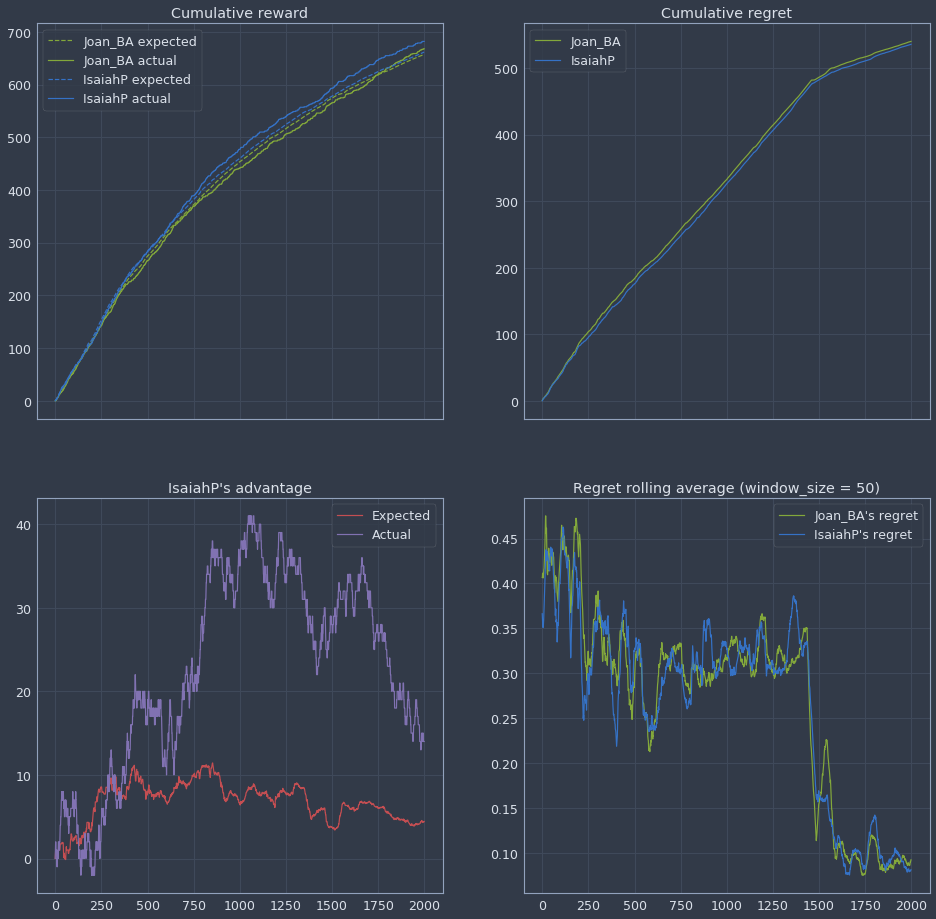

In [9]:
actual_rewards = []
for step in env.steps:
    actual_rewards.append([s["reward"] for s in step])
actual_rewards = np.array(actual_rewards).T
optimal_ev = np.array([max(step[0]["observation"]["thresholds"]) for step in env.steps]) / 100.
regrets = optimal_ev[:-1] - np.diff(data['expected_rewards'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

n_rows = 2
n_cols = 2
plt_fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows),
                             sharex=True
                            )
axes = axes.ravel()

my_color = 0
opp_color = 1
team_names = [tn.encode('ascii', errors='ignore').decode() for tn in env.info.get("TeamNames", ["NA"] * 2)]
my_team_idx = np.argmax(np.array(team_names) == 'IsaiahP')
for i, team_name in enumerate(team_names):
    axes[0].plot(data['expected_rewards'][i], label=f"{team_name} expected",
                 color=colors[my_color if i == my_team_idx else opp_color], linestyle='--')
    axes[0].plot(actual_rewards[i], label=f"{team_name} actual",
                 color=colors[my_color if i == my_team_idx else opp_color])
axes[0].set_title('Cumulative reward')
axes[0].legend()

for i, team_name in enumerate(team_names):
    axes[1].plot(np.cumsum(regrets[i]), label=f"{team_name}",
                 color=colors[my_color if i == my_team_idx else opp_color])
axes[1].set_title('Cumulative regret')
axes[1].legend()

axes[2].plot(data['expected_rewards'][my_team_idx] - data['expected_rewards'][int(not my_team_idx)], label=f"Expected",
             color=colors[2])
axes[2].plot(actual_rewards[my_team_idx] - actual_rewards[int(not my_team_idx)], label=f"Actual",
             color=colors[3])
axes[2].set_title(f"{team_names[my_team_idx]}'s advantage")
axes[2].legend()

window_size = 50
for i, team_name in enumerate(team_names):
    axes[3].plot(filters.uniform_filter1d(regrets[i], window_size, mode='reflect'),
                 label=f"{team_name}'s regret",
                 color=colors[my_color if i == my_team_idx else opp_color])
axes[3].set_title(f'Regret rolling average (window_size = {window_size})')
axes[3].legend();